In [124]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rosbag import Bag

import os
try: data_dir = data_dir = os.path.realpath(os.path.join(os.path.dirname(__file__), '../data'))
except NameError: data_dir = os.path.realpath(os.path.join(globals()['_dh'][0], '../data'))


In [125]:
traject_filename = os.path.join(data_dir, 'trajectory_with_imu.txt')
print(f'reading trajectory from:\n\t{traject_filename}')

trajectory = []
start_time = None
timestamp = 0

with open(traject_filename) as f:    
    x, y, z = [], [], []
    in_points = False
    in_stamp = False
    for line in f:
        if 'stamp' in line:
            in_stamp = True
        elif 'frame_id' in line:
            in_stamp = False
        if in_stamp:
            if 'nsecs' in line:
                nsec = float(line.split(':')[-1])
                timestamp += nsec * 1e-9
                if not start_time:
                    start_time = timestamp
            elif 'secs' in line:
                timestamp = float(line.split(':')[-1])

        # find the start of the section that contains all point
        if 'points' in line:
            in_points = True
            # reset
            x, y, z = [], [], []
        elif 'color' in line:
            in_points = False
        
        if in_points:
            # get the x and y values
            if 'x' in line:
                x.append(float(line.split(':')[-1]))
            if 'y' in line:
                y.append(float(line.split(':')[-1]))
            if 'z' in line:
                z.append(float(line.split(':')[-1]))

times = np.linspace(start_time, timestamp, len(x))
trajectory = pd.DataFrame(zip(times, x, y, z), columns=['timestamp', 'x', 'y', 'z'])

trajectory['timestamp'] = pd.to_datetime(trajectory['timestamp']*1e9, unit='ns')
trajectory = trajectory.set_index('timestamp')

trajectory

reading trajectory from:
	C:\Users\robbi\Documents\GitHub\RPCN\data\trajectory_with_imu.txt


,x,y,z
timestamp,,,
2022-11-30 10:20:54.066980864,0.000000,0.000000,0.0
2022-11-30 10:20:54.101771776,-0.000323,-0.000089,0.0
2022-11-30 10:20:54.136562944,0.003223,0.000491,0.0
2022-11-30 10:20:54.171354112,0.008340,0.002151,0.0
2022-11-30 10:20:54.206145280,0.002694,0.001345,0.0
...,...,...,...
2022-11-30 10:22:55.661821696,0.266141,0.287691,0.0
2022-11-30 10:22:55.696612864,0.266350,0.281892,0.0
2022-11-30 10:22:55.731403776,0.268150,0.275392,0.0


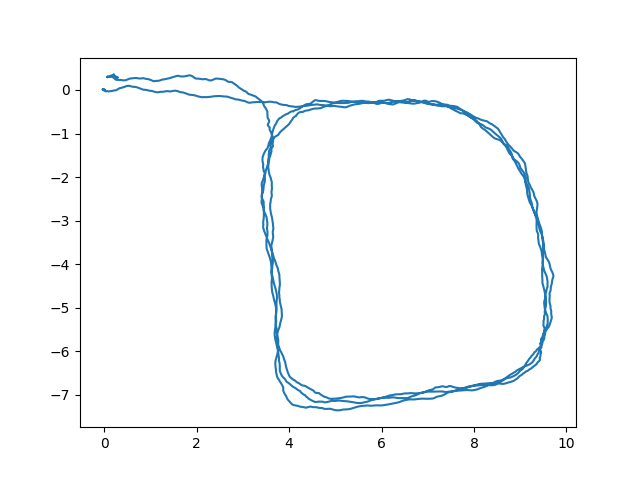

In [126]:
plt.figure()
plt.plot(trajectory['x'], trajectory['y'])
plt.show()

In [127]:
bag_filename = os.path.join(data_dir, 'test3.bag')
print(f'reading lidar scan data from:\n\t{bag_filename}')

def get_xy(msg, scannumber):
    x = np.zeros(shape=[len(msg.ranges)])
    y = np.zeros(shape=[len(msg.ranges)])
    for nr, dist in enumerate(msg.ranges):
        # Lidar returns angle and distance. translate to xy positions
        angle = msg.angle_min + msg.angle_increment * nr
        if(scannumber == 0):
            x[nr] = dist * -np.cos(angle)
            y[nr] = dist * np.sin(angle)
        else:
            x[nr] = dist * np.cos(angle)
            y[nr] = dist * np.sin(angle)
    return x, y

scan0 = []
scan1 = []
for topic, msg, t in Bag(bag_filename):
    if topic == '/scan0':
        scan0.append( get_xy(msg, scannumber=0) )
    elif topic == '/scan1':
        scan1.append( get_xy(msg, scannumber=1) )

        

print(f'Lidar0 has {len(scan0)} scans, each with {len(scan0[0][0])} (x,y) coordinates')
print(f'Lidar1 has {len(scan1)} scans, each with {len(scan1[0][0])} (x,y) coordinates')

reading lidar scan data from:
	C:\Users\robbi\Documents\GitHub\RPCN\data\test3.bag
Lidar0 has 4001 scans, each with 1081 (x,y) coordinates
Lidar1 has 4108 scans, each with 1081 (x,y) coordinates


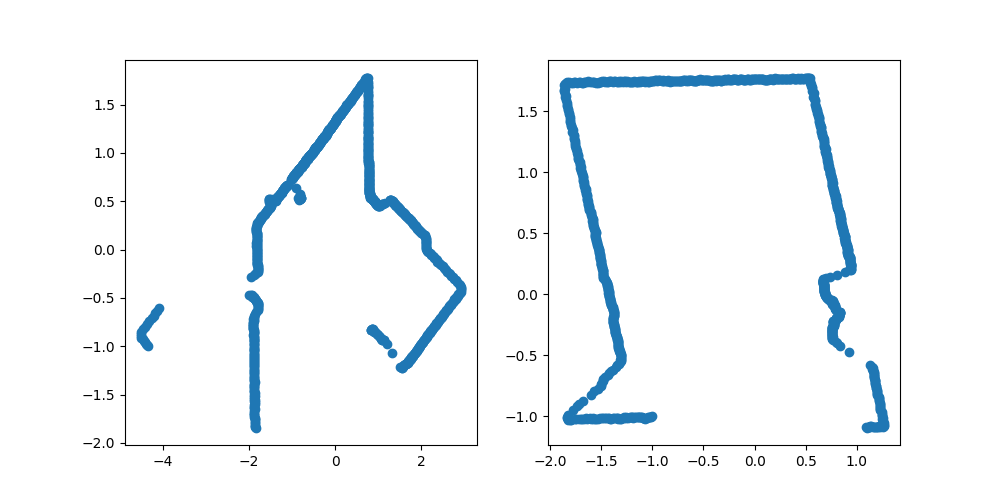

In [128]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(scan0[-1][0],scan0[-1][1])
plt.subplot(1,2,2)
plt.scatter(scan1[-1][0],scan1[-1][1])
plt.show()

In [129]:
print('rotating and translating the scan data to the body frame')

# homogeneous transformations from lidar to body frame
scan0_to_body = np.array([
    [-0.17536324, -0.88242307, -0.43655155,        -0.31542722],
    [ 0.56780261,  0.27159240, -0.77706999,        -0.14370224],
    [ 0.80426857, -0.38414462,  0.45341480,        -0.20138267],
    [ 0.0,         0.0,         0.0,                1.0       ]])

scan1_to_body = np.array([
    [ 0.03916269,  0.87931668,  0.47462455,         0.31813329],
    [-0.53352080,  0.42001741, -0.73412596,        -0.14264865],
    [-0.84487978, -0.22447172,  0.48558275,        -0.19282741],
    [ 0.0,         0.0,         0.0,                1.0       ]])


scan0_rot = []
# apply transformation and translation to each scan
for x, y in scan0:
    # make array of homogeneous coordinates. Z is also 0
    transf_points = np.zeros(shape=[4, len(x)])
    transf_points[0, :] = x
    transf_points[1, :] = y

    # apply homogenous transformation on points
    transf_points = np.dot(scan0_to_body, transf_points)

    # remove 4th value and transpose
    transf_points = transf_points[0:3, :].T
    scan0_rot.append(transf_points)


scan1_rot = []
# apply transformation and translation to each scan
for x, y in scan1:
    # make array of homogeneous coordinates. Z is also 0
    transf_points = np.zeros(shape=[4, len(x)])
    transf_points[0, :] = x
    transf_points[1, :] = y

    # apply homogenous transformation on points
    transf_points = np.dot(scan1_to_body, transf_points)

    # remove 4th value and transpose
    transf_points = transf_points[0:3, :].T
    scan1_rot.append(transf_points)


rotating and translating the scan data to the body frame


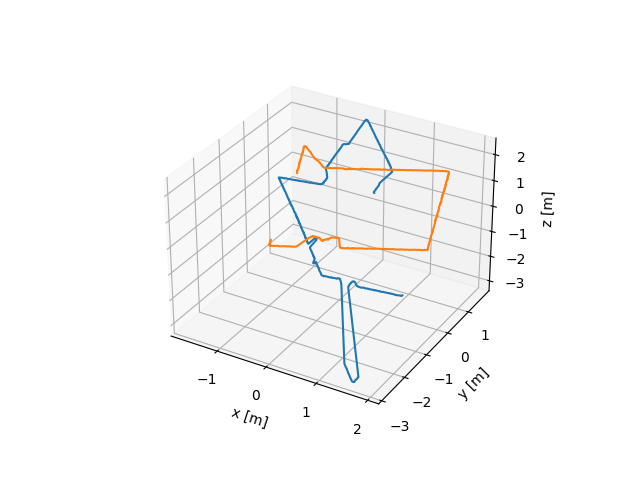

In [130]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(scan0_rot[-1][:, 0], scan0_rot[-1][:, 1], scan0_rot[-1][:, 2], label='scan0')
ax.plot(scan1_rot[-1][:, 0], scan1_rot[-1][:, 1], scan1_rot[-1][:, 2], label='scan1')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

In [131]:
from scipy.spatial.transform import Rotation
import numpy as np
# from sklearn.preprocessing import normalize

print("combining scan data and trajectory into a 3d pointcloud")
def rotateScan(scan_rot,trajectory):
    scan = scan_rot

    # resample the trajectory so that each position corresponds to scan
    traject_duration = trajectory.index[-1] - trajectory.index[0]
    scan_period = traject_duration / len(scan)
    print(f'trajectory has {len(trajectory)} point. there are {len(scan)} scans')
    print(f"\tresampling {traject_duration} trajectory with sampling period of {scan_period}")
    traject = trajectory.resample(scan_period).mean().interpolate(method='linear')

    transformation = np.identity(4)
    RotScan = []
    rotMatrix = []
    new_scan_rot = []
    firstItt = True
    currentPoint = [0,0,0]
    lastRot = np.identity(3)
    for scan_points, row in zip(scan, traject.iterrows()):
        timestamp, (x, y, z) = row
        
        if firstItt:
            firstItt = False
            B = [currentPoint[0]-x,currentPoint[1]-y,currentPoint[2]-z]
            pass
        Newpoint = [x,y,z]
        A = [currentPoint[0]-x,currentPoint[1]-y,currentPoint[2]-z]
        # cross and dot products of A and B
        C = np.cross(B,A)
        D = np.dot(B,A)
        rotation = np.matmul(Rotation.from_quat([C[0], C[1], C[2],D+1]).as_matrix(),lastRot)
        lastRot = rotation
        # make the homogeneous transformation (rotation/translation) matrix 
        homogeneousRot = np.zeros((4,4))
        homogeneousRot[0:3,0:3] = rotation
        homogeneousRot[0:3,3] = A
        homogeneousRot[3,3] = 1

        # make array of homogeneous coordinates. Z is also 0
        transf_points = np.zeros(shape=[4, len(scan_points)])
        transf_points[0, :] = scan_points[:,0]
        transf_points[1, :] = scan_points[:,1]
        transf_points[2, :] = scan_points[:,2]

        transf_points = np.dot(homogeneousRot, transf_points)

        # remove 4th value and transpose
        transf_points = transf_points[0:3, :].T
        new_scan_rot.append(transf_points)

        B = A
        currentPoint = Newpoint

    return new_scan_rot

scan0_new_rot = rotateScan(scan0_rot,trajectory)
scan1_new_rot = rotateScan(scan1_rot,trajectory)



combining scan data and trajectory into a 3d pointcloud
trajectory has 3500 point. there are 4001 scans
	resampling 0 days 00:02:01.734005248 trajectory with sampling period of 0 days 00:00:00.030425894
trajectory has 3500 point. there are 4108 scans
	resampling 0 days 00:02:01.734005248 trajectory with sampling period of 0 days 00:00:00.029633399


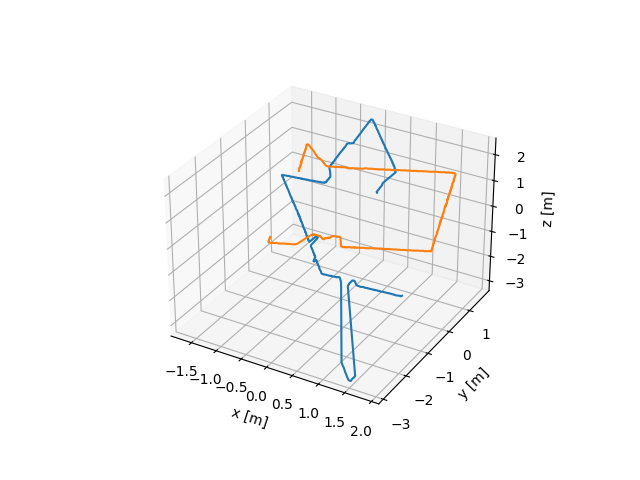

Quitting


In [134]:
from matplotlib.animation import FuncAnimation
# Create the figure and axes
fig = plt.figure()
ax = plt.axes(projection='3d')

# Initialize the data points to be plotted
datapoint = -1
scan0_line, = ax.plot(scan0_new_rot[datapoint][:, 0], scan0_new_rot[datapoint][:, 1], scan0_new_rot[datapoint][:, 2], label='scan0')
scan1_line, = ax.plot(scan1_new_rot[datapoint][:, 0], scan1_new_rot[datapoint][:, 1], scan1_new_rot[datapoint][:, 2], label='scan0')

# Set the axis labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# Define the function to be called for each animation frame
def update(frame):
    global datapoint
    if(datapoint < -4000):
        datapoint = -1
    datapoint -= 1
    scan0_line.set_data(scan0_rot[datapoint][:, 0], scan0_rot[datapoint][:, 1])
    scan0_line.set_3d_properties(scan0_rot[datapoint][:, 2])
    scan1_line.set_data(scan1_rot[datapoint][:, 0], scan1_rot[datapoint][:, 1])
    scan1_line.set_3d_properties(scan1_rot[datapoint][:, 2])

# Create the animation object
ani = FuncAnimation(fig, update, frames=range(len(scan0_rot)), interval=30, blit=True)

running = True

def on_key(event):
    global running
    print(event)
    if event.key == 'p':
        if(running):
            running = False
            print("Pausing")
            ani.event_source.stop()
        else:
            running = True
            print("Resuming")
            ani.event_source.start()
    if event.key == 'q':
        print("Quitting")
        plt.close()

fig.canvas.mpl_connect('key_press_event', on_key)
# Show the animation
plt.show()